# Importing libraries

### Importing all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import cv2
import json

from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import time

%load_ext autoreload
%autoreload 2
import importlib

import Text_preprocessing_tools as tpp
importlib.reload(tpp)

import Image_preprocessing_tools as ipp
importlib.reload(ipp)

<module 'Text_preprocessing_tools' from 'C:\\Ramiro\\Data Science\\0_DataScientest\\02_DS_project\\Raku_ten_23\\Text_preprocessing_tools.py'>

In [2]:
my_seed = 123

# Import text data

In [3]:
# features and target
df_X = pd.read_csv('../datasets/X_train_update.csv', index_col = 0)
df_y = pd.read_csv('../datasets/Y_train_CVw08PX.csv', index_col = 0)

## merge feature and target ? ---> it maybe better for preprocessing, then separate for model training
df = pd.concat([df_y,df_X], axis = 1)
df['prdtypecode'].astype(str)

## class labels
product_class = pd.read_csv('../datasets/product_class.csv', sep = ';').drop('target', axis = 1)
product_class['prdtypecode'].astype(str)
tpp.concat_class_code(product_class)

In [4]:
display(df_X.head())
print("Features dataframe shape = ",df_X.shape)

display(df_y.head())
print("Target dataframe shape = ",df_y.shape)

display(product_class.head())
print("Product Class codes, shape = ",product_class.shape)

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


Features dataframe shape =  (84916, 4)


,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


Target dataframe shape =  (84916, 1)


,prdtypecode,prodtype,class_code
0,10,livres_adulte,livres_adulte___10
1,40,jeux_videos_import,jeux_videos_import___40
2,50,accessoires_jeux_videos,accessoires_jeux_videos___50
3,60,jeux_et_consoles_retro,jeux_et_consoles_retro___60
4,1140,goodies_geek,goodies_geek_1140


Product Class codes, shape =  (27, 3)


### Rename variables

In [5]:
## Rename the variable 'designation' by 'title' which is more convenient

df.rename({'designation':'title'}, axis = 1, inplace = True)
df.head()

,prdtypecode,title,description,productid,imageid
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


# Text Data Exploration and Data Preprocessing

### plot the count of products per category

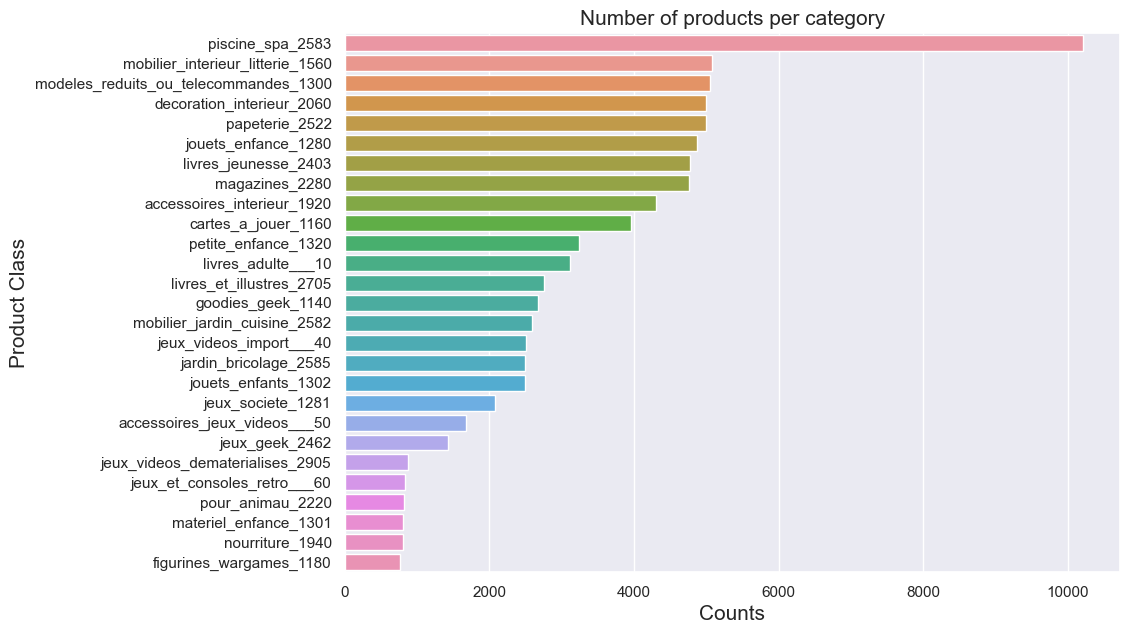

In [6]:
tpp.plot_counts_per_category(df, product_class)

### Plot distribution of missing values

In [7]:
nb_missingDescr = df['description'].isna().sum()
print(f'There are {nb_missingDescr} items ({round(nb_missingDescr/df.shape[0]*100,2)} %) with absent description \n')

display(df.info())

There are 29800 items (35.09 %) with absent description 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prdtypecode  84916 non-null  int64 
 1   title        84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.9+ MB


None

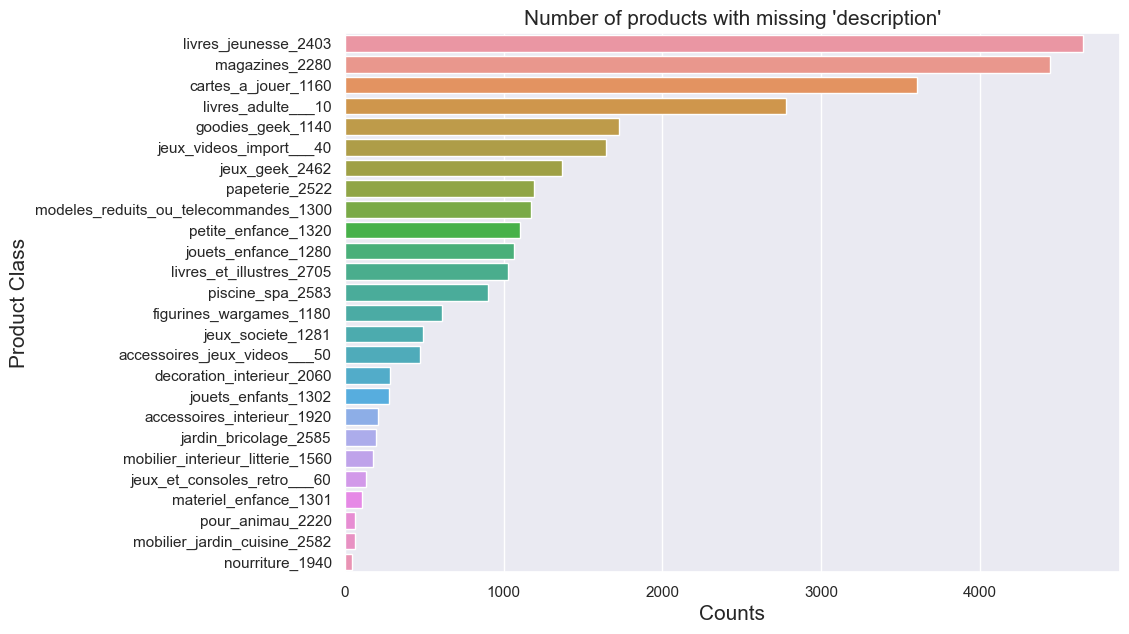

In [8]:
tpp.plot_missing_description_distribution(df, product_class)

## Feature engineering: title_descr
* concatenate 'title' and 'description' into a new variable 'title_descr'.  
* drop the now redundant columns 'title' and 'description'.  

In [9]:
tpp.concatenate_variables(df, 'title', 'description', nans_to = '', separator =' \n ', concat_col_name = 'title_descr', 
                          verbose = True)
df.head()

Columns 'title' and 'description' have been concatenated in a new variable 'title_descr' 



,prdtypecode,title,description,productid,imageid,title_descr
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...,,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...,,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,La Guerre Des Tuques \n Luc a des id&eacute;es...


**Drop redundant variables: Title & Description**

In [10]:
df.drop(['title','description'], axis = 1, inplace = True)

df.head()

,prdtypecode,productid,imageid,title_descr
0,10,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,278535884,1077757786,La Guerre Des Tuques \n Luc a des id&eacute;es...


## HTML encoding

#### Detect proportion of HTML encoding

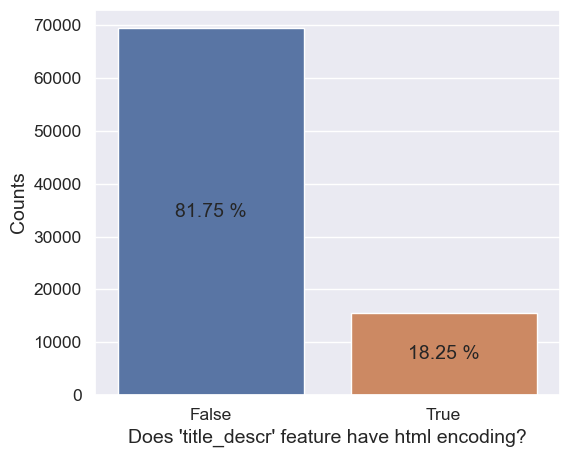

In [11]:
tpp.get_html_encoding_proportion(df, drop = True)

#### HTML parsing and decapitalization

In [12]:
tpp.html_parsing(df, 'title_descr', verbose = True)

Column 'title_descr' has been successfully HTML parsed and decapitalized.
	 HTML parsing takes 22.60 seconds 



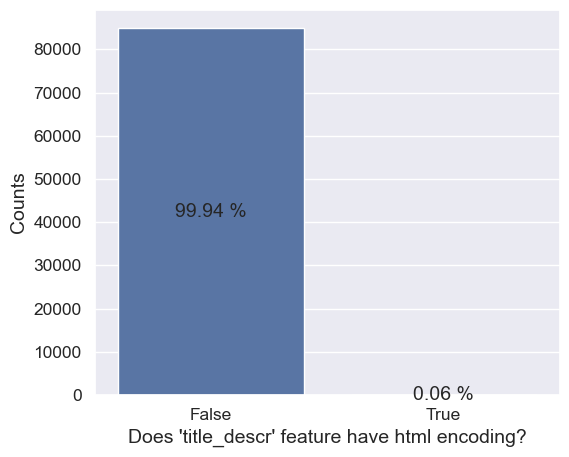

In [13]:
## verify:
tpp.get_html_encoding_proportion(df, drop = True)

In [14]:
df.head()

,prdtypecode,productid,imageid,title_descr
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...
4,2705,278535884,1077757786,la guerre des tuques \n luc a des idées de gra...


## Language detection
<div class="alert alert-warning">
<i class="fa fa-info-circle"></i> &emsp; 
    Language detection takes about 5 minutes. <strong> DO NOT RE DO IT IF NOT NEEDED.</strong>
</div> 

In [15]:
# df2 = df.iloc[:50,:].copy()
tpp.get_language(df, 'title_descr', correct = True, get_probs = True, verbose = True)


Main language detection takes 4.87 minutes.
	 Correction takes 4.59 seconds to crrect 13974 low confidence detections
	 A total of 7476 items have been reclassified as FR and 6498 as EN for simplicity.



In [16]:
df.head()

,prdtypecode,productid,imageid,title_descr,language,lang_prob
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,de,1.0
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,fr,1.0
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,fr,1.0
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,fr,1.0
4,2705,278535884,1077757786,la guerre des tuques \n luc a des idées de gra...,fr,1.0


#### Plot language distributions

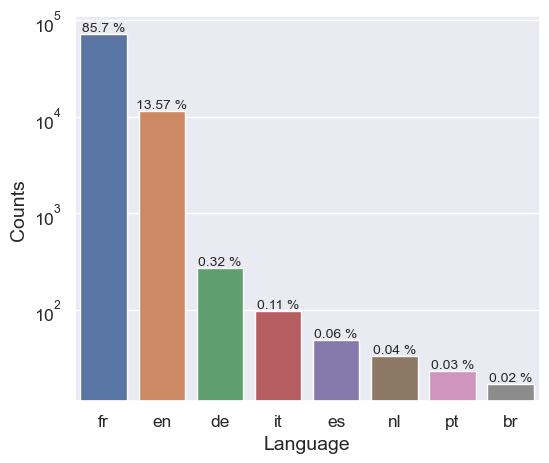

In [17]:
tpp.plot_language_distribution(df, Nb_2show = 8)

## Tokenize & Lemmatize text
* Use a tokenizer that keeps only word of 3 or more word characters: tokenizer = RegexpTokenizer(r"\w{3,}')
* Tokenize title_descr ---> get token lists
* Lematize each token list
* if uniques = True, get the unique lematized tokens (no duplicates). Keeps the order.

In [20]:
tokenizer  = RegexpTokenizer(r'\w{3,}')
lemmatizer = WordNetLemmatizer()

tpp.get_lemmatized_tokens(df, 'title_descr', tokenizer, 'lemma_tokens', lemmatizer, uniques = True)

Column 'title_descr' has been successfully tokenized.
	 Tokenization + Lemmatization takes 27.06 seconds 



In [21]:
df.head()

,prdtypecode,productid,imageid,title_descr,language,lang_prob,lemma_tokens
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,de,1.0,"[olivia, personalisiertes, notizbuch, 150, sei..."
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,fr,1.0,"[journal, de, art, 133, 2001, son, marche, sal..."
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,fr,1.0,"[grand, stylet, ergonomique, bleu, gamepad, ni..."
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,fr,1.0,"[peluche, donald, europe, disneyland, 2000, ma..."
4,2705,278535884,1077757786,la guerre des tuques \n luc a des idées de gra...,fr,1.0,"[guerre, de, tuques, luc, idées, grandeur, veu..."


### Remove stop words

In [22]:
tpp.remove_stop_words(df, 'lemma_tokens', 'lemma_tokens', 'language', verbose = True)

Removing stop-words takes 34.16 seconds. 



In [23]:
df.head()

,prdtypecode,productid,imageid,title_descr,language,lang_prob,lemma_tokens
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,de,1.0,"[olivia, personalisiertes, notizbuch, 150, sei..."
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,fr,1.0,"[journal, art, 133, 2001, marche, salon, asiat..."
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,fr,1.0,"[grand, stylet, ergonomique, bleu, gamepad, ni..."
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,fr,1.0,"[peluche, donald, europe, disneyland, 2000, ma..."
4,2705,278535884,1077757786,la guerre des tuques \n luc a des idées de gra...,fr,1.0,"[guerre, tuques, luc, idées, grandeur, veut, o..."


### Most common words per category

In [24]:
tpp.get_category_top_words(df, product_class, Nb_top_words = 8)


## chose which categories to display the most common words
## Set to_show() = 'all' to see every category

categories_to_show = [50, 1160, 1940, 2280, 2583]
tpp.display_category_top_words(product_class, to_show = categories_to_show)

,class_code,common_words
2,accessoires_jeux_videos___50,"[jeu, console, nintendo, haute, protection, compatible, manette, facile]"
5,cartes_a_jouer_1160,"[carte, magic, mtg, rare, commune, dragon, pokemon, pokémon]"
15,nourriture_1940,"[sucre, marque, bio, produit, sachet, ingrédients, café, lait]"
18,magazines_2280,"[france, journal, paris, revue, monde, magazine, petit, vie]"
23,piscine_spa_2583,"[piscine, eau, filtration, dimension, sol, pompe, kit, bleu]"


## Feature engineering: token_length
* Here the token count is performed after removing the stop words. The token count coudl also be done before removing stop words, the important thing is to keep the same protocol for all items in the dataframe.
    
* Another option could be simply to get the counts before and after removing the stop words and short tokens. In this scenario one can get token_len_raw counting short tokens and a token_len without them.

In [25]:
tpp.get_token_length(df, 'lemma_tokens', 'text_token_len', verbose = True)
df.head()

Token counting takes 0.03 seconds. 



,prdtypecode,productid,imageid,title_descr,language,lang_prob,lemma_tokens,text_token_len
0,10,3804725264,1263597046,olivia: personalisiertes notizbuch / 150 seite...,de,1.0,"[olivia, personalisiertes, notizbuch, 150, sei...",9
1,2280,436067568,1008141237,journal des arts (le) n° 133 du 28/09/2001 - l...,fr,1.0,"[journal, art, 133, 2001, marche, salon, asiat...",20
2,50,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,fr,1.0,"[grand, stylet, ergonomique, bleu, gamepad, ni...",50
3,1280,50418756,457047496,peluche donald - europe - disneyland 2000 (mar...,fr,1.0,"[peluche, donald, europe, disneyland, 2000, ma...",7
4,2705,278535884,1077757786,la guerre des tuques \n luc a des idées de gra...,fr,1.0,"[guerre, tuques, luc, idées, grandeur, veut, o...",18


### Display a descriptive statistics

In [26]:
df_stat = pd.DataFrame(df['text_token_len'].describe())
df_stat['text_token_len'] = [round(val,2) for val in df_stat['text_token_len']]
df_stat

,text_token_len
count,84916.00
mean,38.35
std,39.44
min,0.00
25%,7.00
50%,23.00
75%,61.00
max,515.00


### Plot token length distribution 

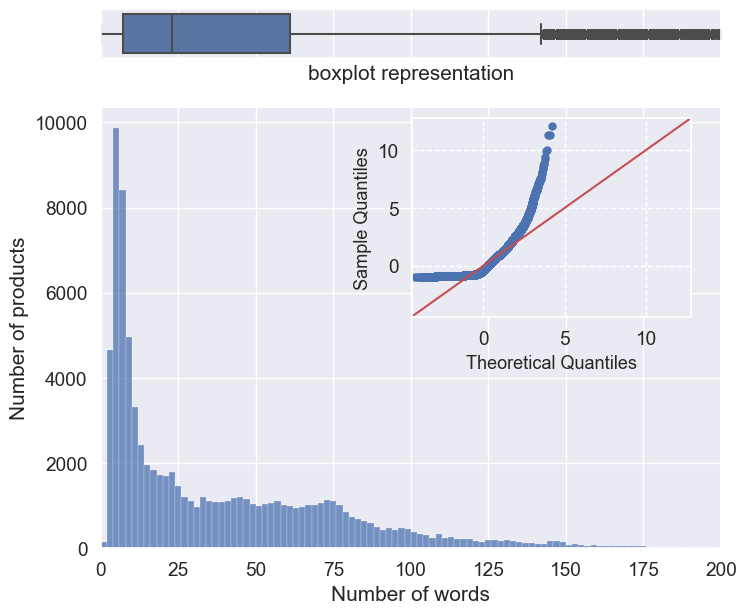

In [27]:
tpp.plot_token_len_distribution(df, xRange = [0,200], qqplot = True, quantiles = False) #[0,500]

### Run statitical test
* Distribution of token length per category
* ANOVA test

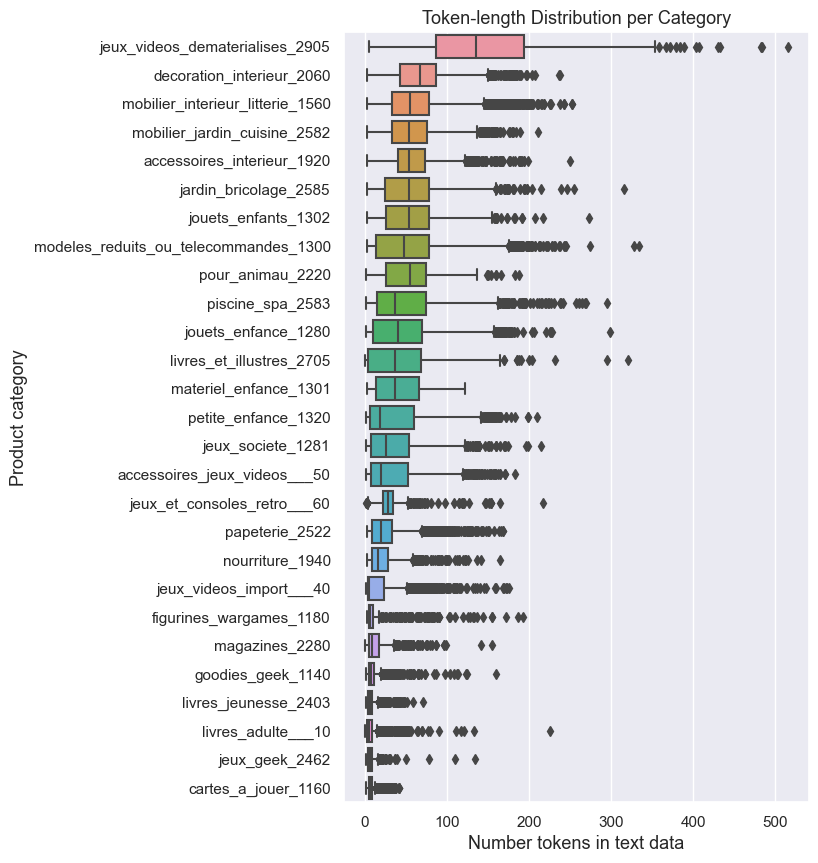

In [28]:
tpp.plot_token_len_distribution_per_category(df, product_class)

**ANOVA test**

In [29]:
H0 = "There is NO correlation between 'text_token_len' and 'prdtypecode'"
H1 = "There is a correlation between  'text_token_len' and 'prdtypecode'"

In [30]:
tpp.run_anova_test(df,'text_token_len', 'prdtypecode')

,df,sum_sq,mean_sq,F,PR(>F)
prdtypecode,1.0,3.253826e+06,3.253826e+06,2145.152698,0.0
Residual,84914.0,1.287999e+08,1.516827e+03,NaN,NaN


H0 is rejected, H1 is accepted
ANOVA p-value =  0.0


## Save Preprocessed text data

In [26]:
write = False

if write:    
    path = ''
    filename = 'df_text_preprocessed' + date_time() + '.csv'
    
    df.to_csv(filename, header=True, index=False)
    print(filename)

df_text_preprocessed_20230807_2212.csv


# _______________________________________________________________
# Image Data Exploration


In [37]:
import Image_preprocessing_tools as ipp
importlib.reload(ipp)

<module 'Image_preprocessing_tools' from 'C:\\Ramiro\\Data Science\\0_DataScientest\\02_DS_project\\Raku_ten_23\\Image_preprocessing_tools.py'>

## Display some images

**chose the image indices withing the range of len(df). This arr the image ids**

3
../datasets/image_train/image_935392495_product_194649135.jpg
../datasets/image_train/image_1248390762_product_3814898009.jpg
../datasets/image_train/image_1148154575_product_2536863974.jpg


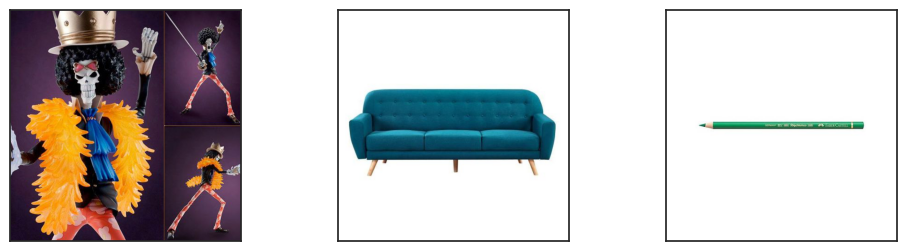

In [57]:

ipp.show_images(df, index = [5606,444,27])

**show image from specific category**

,prdtypecode,prodtype
15,1940,nourriture


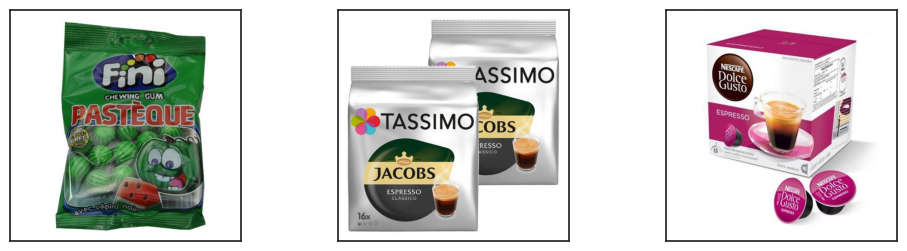

In [79]:

show_image_from_category(df, product_class, category = 'nourriture')

**show a single image from a category. Add markers and zoom to explore in detail.**

../datasets/image_train/image_1020016710_product_516282879.jpg


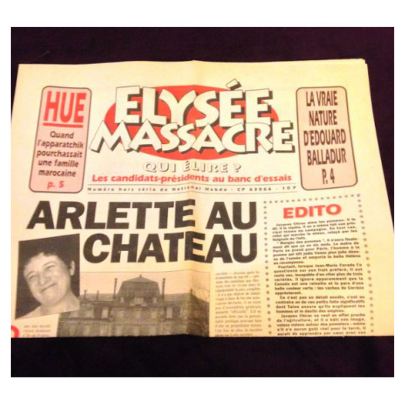

In [121]:

ipp.show_single_image_from_category(df, product_class, category= 2280, item = 154)
# show_single_image_from_category(df, product_class, category= 10, item = 157, zoom = [0,250,0,250], mark = [200,150])

## crop backgroud white color

**Chose an image from the problematic category**

In [122]:
## verify with one example image: someexamples are idx = 63, 11, 12, 1231, 104 (it shouldn't crop), 153, 84830 (not centered)
## others 17798, 55798

idx = 84

## load image 
file = "../datasets/image_train/image_"+str(df.loc[idx,'imageid'])+"_product_"+str(df.loc[idx,'productid'])+".jpg"
image = cv2.imread(file)
print(file)


../datasets/image_train/image_1065997226_product_1158987675.jpg


**Find new boundaries given a threshold RGB intensity. Then plot before / after cropping**  


In [125]:
#image = test_matrix
threshold = 230

# Calculate the boundaries (assuming you have the threshold defined)
left_boundary = ipp.find_left_boundary(image, threshold)
right_boundary = ipp.find_right_boundary(image, threshold)
top_boundary = ipp.find_top_boundary(image, threshold)
bottom_boundary = ipp.find_bottom_boundary(image, threshold)

print("Left Boundary:", left_boundary)
print("Right Boundary:", right_boundary)
print("top Boundary:", top_boundary)
print("bottom Boundary:", bottom_boundary)

# Crop the image using the calculated boundaries
cropped_image = ipp.crop_square(image, left_boundary, right_boundary, top_boundary, bottom_boundary)

Left Boundary: 109
Right Boundary: 389
top Boundary: 144
bottom Boundary: 354


**Plot the before / after cropping**

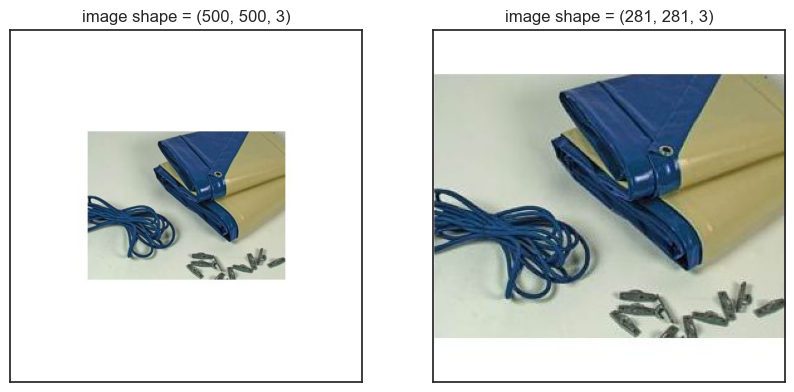

In [127]:
sns.set_style("white")
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(image[:,:,::-1])
axs[1].imshow(cropped_image[:,:,::-1])

axs[0].set_title("image shape = " + str(image.shape))
axs[1].set_title("image shape = " + str(cropped_image.shape))

for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
sns.set()


## Resize cropped image (downscale)

In [128]:
## define the final number of pixels per side: try 100 or 224
Nb_px = 224
resized_image = cv2.resize(cropped_image, (Nb_px, Nb_px)) 


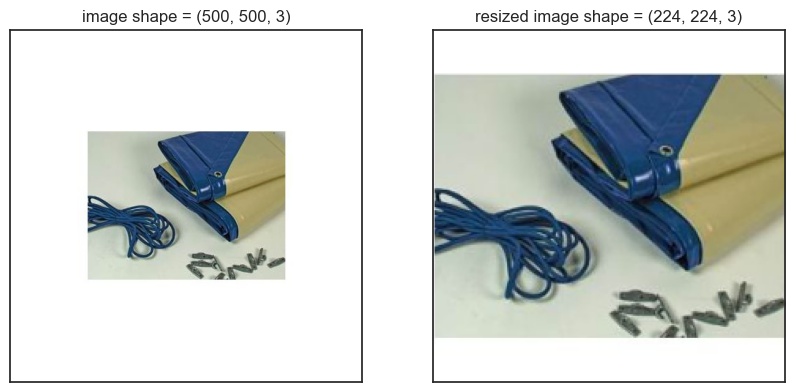

In [129]:
## plot images

sns.set_style("white")
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(image[:,:,::-1])
axs[1].imshow(resized_image[:,:,::-1])

axs[0].set_title("image shape = " + str(image.shape))
axs[1].set_title("resized image shape = " + str(resized_image.shape))

for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
sns.set()


## Image vectorization
* Each image should be represented as a flattened string in order to processed by most of the machine learning models.

In [130]:
print("initial image shape:", resized_image.shape)

Nx, Ny, Nch = resized_image.shape
vector_image = resized_image.reshape(Nx*Ny*Nch)

print("final vectorized image shape:", vector_image.shape)

initial image shape: (224, 224, 3)
final vectorized image shape: (150528,)


## Transform and Vectorize the whole dataframe
* cropping white background
* resizing images
* vectorizing images

* save vector(size = N) into a dataframe with N columns (pixels)

In [131]:
df_vectorized_images = ipp.preprocess_image_data(df, threshold = 230, new_pixel_nb = 100, 
                                                 path = '../datasets/image_train/', output ='dataframe', verbose = True)

0 images at time 0.00 minutes
1000 images at time 0.13 minutes
2000 images at time 0.26 minutes
3000 images at time 0.38 minutes
4000 images at time 0.51 minutes
5000 images at time 0.64 minutes
10000 images at time 1.29 minutes
15000 images at time 1.93 minutes
20000 images at time 2.56 minutes
25000 images at time 3.20 minutes
30000 images at time 3.83 minutes
35000 images at time 4.46 minutes
40000 images at time 5.13 minutes
45000 images at time 5.76 minutes
50000 images at time 6.39 minutes
55000 images at time 7.02 minutes
60000 images at time 7.66 minutes
65000 images at time 8.29 minutes
70000 images at time 8.92 minutes
75000 images at time 9.54 minutes
80000 images at time 10.17 minutes
Vectorization of 84916 images takes 10.79 minutes


In [133]:
df_vectorized_images.head()

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


#### Save the vectorized image dataset
* saving the dataset as array is more efficient that as dataframe

In [132]:
ipp.save(datasets = [df_vectorized_images], \
            types = ['dataframe'], \
             names = ['df_vectorized_images_100px'], \
              path = '', doit = False, verbose = True)

Datasets were not saved locally. Set doit = True to store them


## Get Average RGB intensity for every Image
**important:** The following cell takes >5 (<10) minutes.  
<span style='color: #000000; font-family: monospace; background-color: #f1c232;'>
Do not run, but instead load the previously calculation
</span>
(See section below)

**fetching images is faster (but his are not the cropped images!!)**  
0 images at time 0.00 minutes  
1000 images at time 0.10 minutes  
5000 images at time 0.48 minutes  
10000 images at time 0.97 minutes  
80000 images at time 7.51 minutes  
Getting mean RGB for 84916 images takes 7.97 minutes  

**reconstructing cropped images takes:**  
1000 images at time 0.26 minutes  
5000 images at time 1.32 minutes  
10000 images at time 2.65 minutes  
80000 images at time 21.68 minutes  
Getting mean RGB for 84916 images takes 23.04 minutes

In [78]:
recalculate_meanRGBs = False #True

if recalculate_meanRGBs:
    meanRGBs = get_image_mean_RGB(df_vectorized_images, image_type='cropped', 100)


0 images at time 0.00 minutes
1000 images at time 0.27 minutes
2000 images at time 0.55 minutes
3000 images at time 0.82 minutes
4000 images at time 1.11 minutes
5000 images at time 1.38 minutes
10000 images at time 2.74 minutes
15000 images at time 4.13 minutes
20000 images at time 5.78 minutes
25000 images at time 7.14 minutes
30000 images at time 8.51 minutes
35000 images at time 9.86 minutes
40000 images at time 11.21 minutes
45000 images at time 12.64 minutes
50000 images at time 14.00 minutes
55000 images at time 15.35 minutes
60000 images at time 16.70 minutes
65000 images at time 18.05 minutes
70000 images at time 19.39 minutes
75000 images at time 20.77 minutes
80000 images at time 22.12 minutes
Getting mean RGB for 84916 images takes 23.44 minutes


**Concatenate id columns, mean RGb values and, pixel data**

In [86]:
print(meanRGBs.shape)

## add values into dataframe columns
df_vectorized_images.insert(loc=0, column='prdtypecode', value=df.loc[:,'prdtypecode'])
df_vectorized_images.insert(loc=1, column='productid', value=df.loc[:,'productid'])
df_vectorized_images.insert(loc=2, column='imageid', value=df.loc[:,'imageid'])

df_vectorized_images.insert(loc=3, column='meanR', value=meanRGBs[:,0])
df_vectorized_images.insert(loc=4, column='meanG', value=meanRGBs[:,1])
df_vectorized_images.insert(loc=5, column='meanB', value=meanRGBs[:,2])

df_vectorized_images.head()

(84916, 3)


,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,px_3,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,10,3804725264,1263597046,205.4529,206.5443,234.1815,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,436067568,1008141237,167.7998,172.5678,176.3561,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,201115110,938777978,251.9491,248.2853,244.1458,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,50418756,457047496,76.9653,82.1617,111.9041,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,278535884,1077757786,209.4138,198.2848,174.6685,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


#### Save the vectorized image dataset with the mean RGBs
** save it as numpy array. it takes less space an memory (npz optionally)

In [132]:
ipp.save(datasets = [df_vectorized_images], \
            types = ['dataframe'], \
             names = ['df_vectorized_images_100px'], \
              path = '', doit = False, verbose = True)

Datasets were not saved locally. Set doit = True to store them


### Load Preprocessed image dataframe

In [134]:
### test recover df from pickle (if saved with pickle otherwise choose the appropiate method) 
read_df_meanRGBs = True
filename = './to_check_Preprocessed_data/df_vectorized_images_meanRGBs' + '.pkl'

t0 = time.time()

if read_df_meanRGBs:
    df_images = pd.read_pickle(filename)

    display(df_images.head())
    print(df_images.shape)

print("Total time to read = %0.2f seconds" %(time.time()-t0))    

,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,px_3,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,10,3804725264,1263597046,205.4529,206.5443,234.1815,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,436067568,1008141237,167.7998,172.5678,176.3561,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,201115110,938777978,251.9491,248.2853,244.1458,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,50418756,457047496,76.9653,82.1617,111.9041,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,278535884,1077757786,209.4138,198.2848,174.6685,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


(84916, 30006)
Total time to read = 3.47 seconds


### Color Distributions:   
distribution of $\overline{R}_{img}$, $\overline{G}_{img}$ and $\overline{B}_{img}$ in the whole dataset all mixed.

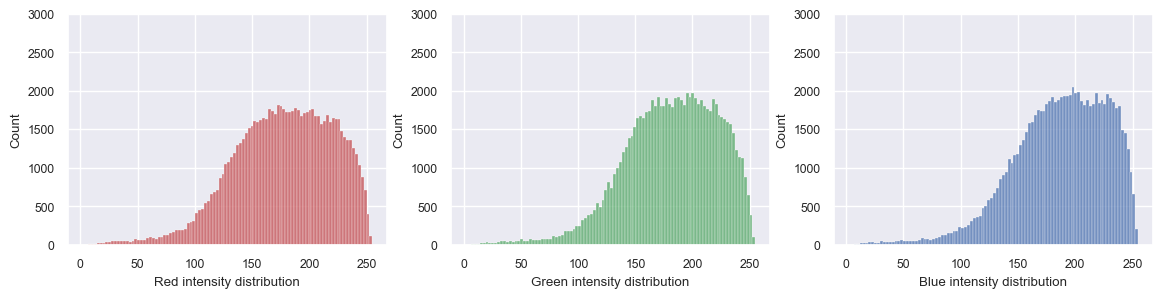

In [138]:
sns.set(font_scale = 0.8)
ylim = 3000

fig, axs = plt.subplots(1,3,figsize=(14,3) )
#fig.suptitle("Average image RGB intensities distributions")

sns.histplot(df_images.meanR, bins = 100, ax = axs[0], color = 'r').set(ylim=(0, ylim))
axs[0].set_xlabel("Red intensity distribution")
sns.histplot(df_images.meanG, bins = 100, ax = axs[1], color = 'g').set(ylim=(0, ylim))#, yticklabels=[], ylabel=None
axs[1].set_xlabel("Green intensity distribution")
sns.histplot(df_images.meanB, bins = 100, ax = axs[2], color = 'b').set(ylim=(0, ylim))
axs[2].set_xlabel("Blue intensity distribution")
sns.set()


### Mean RGB intensity per category
* repressentative average channel value per category (mean of means): $\overline{R}_{cat}$, $\overline{G}_{cat}$ and $\overline{B}_{cat}$

In [141]:
RGB_per_cat = df_images[['prdtypecode','meanR','meanG','meanB']].groupby('prdtypecode')['meanR','meanG','meanB'].mean()

RGB_per_cat.head()

C:\Users\19rod\AppData\Local\Temp\ipykernel_4680\2902228034.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  RGB_per_cat = df_images[['prdtypecode','meanR','meanG','meanB']].groupby('prdtypecode')['meanR','meanG','meanB'].mean()


,meanR,meanG,meanB
prdtypecode,,,
10,164.672125,173.900505,181.811280
40,154.848153,160.053910,167.365718
50,179.171735,180.284372,183.397090
60,173.713197,174.356024,178.503859
1140,171.882739,176.053288,183.304761


<ins>**Visualisation**</ins>

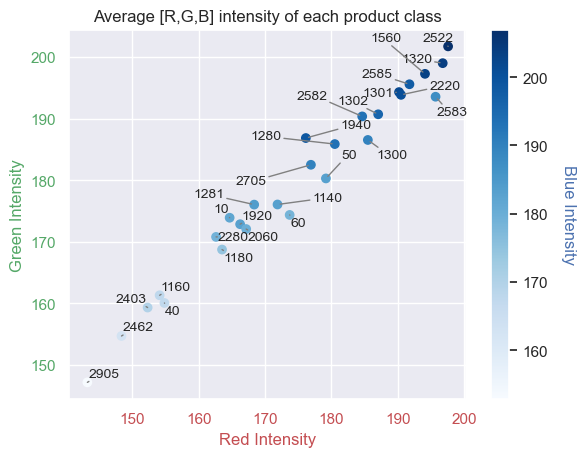

In [143]:
from adjustText import adjust_text

red_values = RGB_per_cat['meanR'].values
green_values = RGB_per_cat['meanG'].values
blue_values = RGB_per_cat['meanB'].values

# Scatter plot
plt.scatter(red_values, green_values, c=blue_values, cmap="Blues")
#plt.scatter(green_values, blue_values, c=red_values)
#plt.scatter(blue_values, red_values, c=green_values)

#Create a list of text annotations
image_names = RGB_per_cat.index
annotations = []
for i, name in enumerate(image_names):
    annotations.append(plt.text(red_values[i], green_values[i], name, fontsize=10))

# Adjust the text labels to avoid overlap
adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='grey'), force_points=2.0, force_text=1.5)

plt.title('Average [R,G,B] intensity of each product class')
plt.xlabel('Red Intensity', color = 'r')
plt.ylabel('Green Intensity', color = 'g')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Blue Intensity', rotation=270, labelpad = 20, fontdict = {"size":12}, color = 'b')

plt.tick_params(axis='x', colors='r')
plt.tick_params(axis='y', colors='g')
plt.show();

### Try adding to this plot all images from category 60 to see if they cluster around the mean value or not.

In [144]:
df_images_1cat = df_images[df_images['prdtypecode'] == 60]

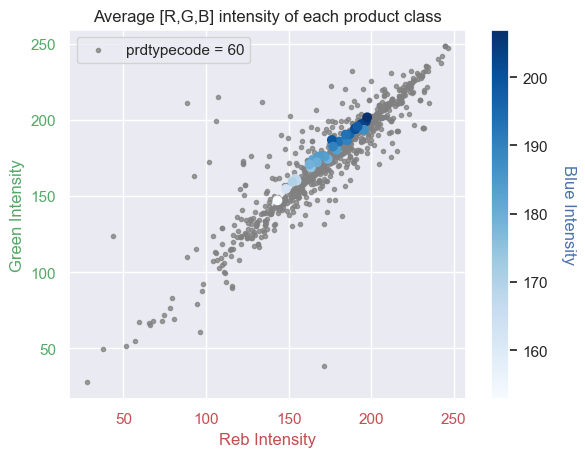

In [145]:
red_values = RGB_per_cat['meanR'].values
green_values = RGB_per_cat['meanG'].values
blue_values = RGB_per_cat['meanB'].values


# Scatter plot
plt.scatter(df_images_1cat.meanR, df_images_1cat.meanG, marker = '.', alpha = 0.75, label = "prdtypecode = 60", color = 'Gray')
plt.scatter(red_values, green_values, c=blue_values, cmap="Blues")
# plt.scatter(green_values, blue_values, c=red_values)
# plt.scatter(blue_values, red_values, c=green_values)

#Create a list of text annotations
# image_names = RGB_per_cat.index
# annotations = []
# for i, name in enumerate(image_names):
#     annotations.append(plt.text(blue_values[i], red_values[i], name, fontsize=10))

# # Adjust the text labels to avoid overlap
# adjust_text(annotations, arrowprops=dict(arrowstyle='-', color='grey'), force_points=2.0, force_text=1.5)

plt.title('Average [R,G,B] intensity of each product class')
plt.xlabel('Reb Intensity', color = 'r')
plt.ylabel('Green Intensity', color = 'g')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Blue Intensity', rotation=270, labelpad = 20, fontdict = {"size":12}, color = 'b')

plt.tick_params(axis='x', colors='r')
plt.tick_params(axis='y', colors='g')
plt.legend()
plt.show();

<ins>**ANOVA test**</ins>

In [146]:
# Import the library
import statsmodels.api

# hypothesis:
H0 = "There is No correlation between 'meanRGB' and 'prdtypecode'"
H1 = "There IS a correlation between 'meanRGB' and 'prdtypecode'"

## Realize the ANOVA test and display the results
## Try 'title_char_len', 'descr_char_len' or 'text_token_len'
result = statsmodels.formula.api.ols('meanB ~ prdtypecode', data=df_images).fit()
table = statsmodels.api.stats.anova_lm(result)

# get p-val an evaluate criteria
display(table)
p_val_anova = table.loc['prdtypecode','PR(>F)']

# evaluation
alpha = 0.05
def p_val_evaluation(p_val, alpha, H0, H1):
    if p_val >= alpha:
        print("H0 is not rejected \n H0:",H0)
    else:
        print("H0 is rejected, H1 is accepted \n H1:",H1)

print("ANOVA p-value = ", p_val_anova)
p_val_evaluation(p_val_anova,alpha, H0, H1)

,df,sum_sq,mean_sq,F,PR(>F)
prdtypecode,1.0,2.062858e+05,206285.812085,122.883632,1.546994e-28
Residual,84914.0,1.425459e+08,1678.708624,NaN,NaN


ANOVA p-value =  1.5469935243042498e-28
H0 is rejected, H1 is accepted 
 H1: There IS a correlation between 'meanRGB' and 'prdtypecode'


###  Mean RGB distribution per catgory can also be sene with a bar plot

In [147]:
RGB_per_cat.reset_index(inplace=True)
RGB_per_cat['prdtypecode'] = RGB_per_cat['prdtypecode'].astype(str)
display(RGB_per_cat.head())


,prdtypecode,meanR,meanG,meanB
0,10,164.672125,173.900505,181.811280
1,40,154.848153,160.053910,167.365718
2,50,179.171735,180.284372,183.397090
3,60,173.713197,174.356024,178.503859
4,1140,171.882739,176.053288,183.304761


In [148]:
display(RGB_per_cat.sort_values(by = 'meanB', ascending = True).head())

sorted_by_B = RGB_per_cat.sort_values(by = 'meanB', ascending = False)['prdtypecode'].to_list()
print(sorted_by_B)

,prdtypecode,meanR,meanG,meanB
26,2905,143.244161,147.161821,152.837240
20,2462,148.385787,154.693262,162.779558
1,40,154.848153,160.053910,167.365718
5,1160,154.127280,161.305093,167.557817
19,2403,152.321250,159.314675,169.907213


['2522', '1320', '1560', '1301', '2220', '1940', '2585', '1302', '1280', '2582', '2705', '1300', '2583', '1281', '50', '1140', '1920', '10', '2060', '2280', '60', '1180', '2403', '1160', '40', '2462', '2905']


Text(0.5, 1.0, 'Average R, G and B intensity per product category')

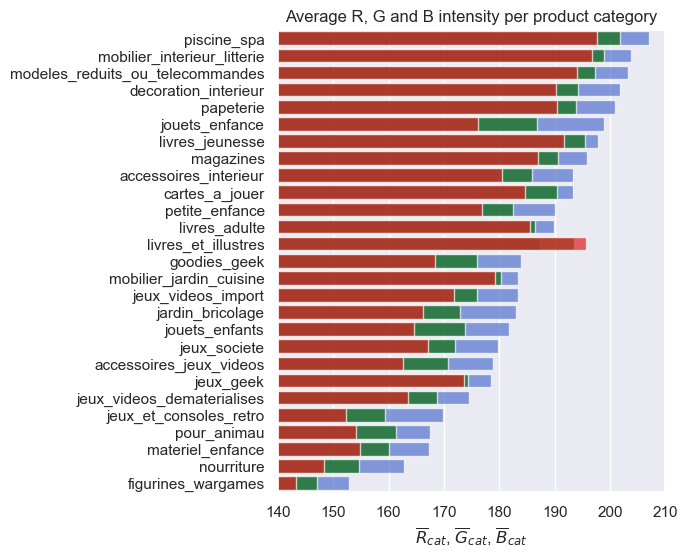

In [149]:
sns.set()

f, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,6))

class_codes = df['prdtypecode'].value_counts().index
class_labels = [ product_class.loc[product_class['prdtypecode']==code,'prodtype'].iloc[0] for code in class_codes]

sns.barplot(data=RGB_per_cat, y="prdtypecode", x="meanB", order = sorted_by_B, color = 'royalblue', alpha = 0.7)
sns.barplot(data=RGB_per_cat, y="prdtypecode", x="meanG", order = sorted_by_B, color = 'green', alpha = 0.7)
sns.barplot(data=RGB_per_cat, y="prdtypecode", x="meanR", order = sorted_by_B, color = 'red', alpha = 0.7)

ax.set_yticklabels(class_labels)
plt.ylabel('')
plt.xlabel('$\overline{R}_{cat}$, $\overline{G}_{cat}$, $\overline{B}_{cat}$')
plt.xlim([140,210])
plt.title("Average R, G and B intensity per product category")


# Prove that data is randomly gathered
Probe that there is no correlation between index of the observation and category.

In [150]:
df_images_indexed = df_images.reset_index()
df_images_indexed.head()

,index,prdtypecode,productid,imageid,meanR,meanG,meanB,px_0,px_1,px_2,...,px_29990,px_29991,px_29992,px_29993,px_29994,px_29995,px_29996,px_29997,px_29998,px_29999
0,0,10,3804725264,1263597046,205.4529,206.5443,234.1815,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,1,2280,436067568,1008141237,167.7998,172.5678,176.3561,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,2,50,201115110,938777978,251.9491,248.2853,244.1458,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,1280,50418756,457047496,76.9653,82.1617,111.9041,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,4,2705,278535884,1077757786,209.4138,198.2848,174.6685,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [151]:
# Import the library
import statsmodels.api

# hypothesis:
H0 = "There is No correlation between 'index' and 'prdtypecode'"
H1 = "There IS a correlation between 'index' and 'prdtypecode'"

## Realize the ANOVA test and display the results
## Try 'title_char_len', 'descr_char_len' or 'text_token_len'
result = statsmodels.formula.api.ols('index ~ prdtypecode', data=df_images_indexed).fit()
table = statsmodels.api.stats.anova_lm(result)

# get p-val an evaluate criteria
display(table)
p_val_anova = table.loc['prdtypecode','PR(>F)']

# evaluation
alpha = 0.05
def p_val_evaluation(p_val, alpha, H0, H1):
    if p_val >= alpha:
        print("H0 is not rejected \n H0:",H0)
    else:
        print("H0 is rejected, H1 is accepted \n H1:",H1)

print("ANOVA p-value = ", p_val_anova)
p_val_evaluation(p_val_anova,alpha, H0, H1)

,df,sum_sq,mean_sq,F,PR(>F)
prdtypecode,1.0,2.954091e+04,2.954091e+04,0.000049,0.994406
Residual,84914.0,5.102551e+13,6.009081e+08,NaN,NaN


ANOVA p-value =  0.9944057339979936
H0 is not rejected 
 H0: There is No correlation between 'index' and 'prdtypecode'
